# CLIP GradCAM Colab

This Colab notebook uses [GradCAM](https://arxiv.org/abs/1610.02391) on OpenAI's [CLIP](https://openai.com/blog/clip/) model to produce a heatmap highlighting which regions in an image activate the most to a given caption.

**Note:** Currently only works with the ResNet variants of CLIP. ViT support coming soon.

In [1]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.

#capture
#!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
#!pip install git+https://github.com/openai/CLIP.git

import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn
import matplotlib.patches as patches

In [15]:
#@title Helper functions

#@markdown Some helper functions for overlaying heatmaps on top
#@markdown of images and visualizing with matplotlib.

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, question, answers, correct_answer, layer,blur=True):
    _, axes = plt.subplots(3, 7, figsize=(10, 5))
    # question as title for whole image
    plt.suptitle(question + " - " + str(layer))
    for i in range(20):
        #print(i, ": ", i//7, i%7)
        if i == 0:
            axes[0][0].imshow(img)
            # add question as title
            axes[0][0].set_title("Original")
            axes[0][0].axis("off")
        elif i == 1:
            axes[i//7][i%7].imshow(getAttMap(img, attn_map[i-1], blur))
            axes[i//7][i%7].set_title("Question", color='red')
            
            rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='red', facecolor='none',
                                     transform=axes[i // 7][i % 7].transAxes)
            axes[i // 7][i % 7].add_patch(rect)
            axes[i//7][i%7].axis("off")
        elif (i-2) == int(correct_answer):
            print("correct")
            axes[i//7][i%7].imshow(getAttMap(img, attn_map[i-1], blur))
            axes[i//7][i%7].set_title(answers[i-2], color='green')
            rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='green', facecolor='none',
                                     transform=axes[i // 7][i % 7].transAxes)
            axes[i // 7][i % 7].add_patch(rect)

            axes[i//7][i%7].axis("off")     
        else:
            axes[i//7][i%7].imshow(getAttMap(img, attn_map[i-1], blur))
            axes[i//7][i%7].set_title(answers[i-2])
            axes[i//7][i%7].axis("off")
        
        
    for ax in axes:
        for a in ax:
            a.axis("off")
            
    
    #axes[1].imshow(getAttMap(img, attn_map, blur))
    
    plt.tight_layout()
    plt.show()
    
def viz_attn2(img, attn_map, question, answers, correct_answer, layer, blur=True):
    # same vis but only for original, question and one answer
    print(len(answers) + 2)
    _, axes = plt.subplots(1, len(answers) + 2, figsize=(10, 5))
    # question as title for whole image
    plt.suptitle(question + " - " + str(layer))
    axes[0].imshow(img)
    # add question as title
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(getAttMap(img, attn_map[0], blur))
    axes[1].set_title("Question", color='red')
    rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='red', facecolor='none',
                                     transform=axes[1].transAxes)
    axes[1].add_patch(rect)
    axes[1].axis("off")
    for i, answer in enumerate(answers):

        print(i, ": ", i+2)
        axes[i+2].imshow(getAttMap(img, attn_map[i+1], blur))
        if i == int(correct_answer):
            axes[i+2].set_title(answer, color='green')
            rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='green', facecolor='none',
                                     transform=axes[i+2].transAxes)
            axes[i+2].add_patch(rect)
        else:
            axes[i+2].set_title(answer)
        axes[i+2].axis("off")
    plt.tight_layout()
    plt.show()




def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

In [3]:
#@title GradCAM: Gradient-weighted Class Activation Mapping

#@markdown Our gradCAM implementation registers a forward hook
#@markdown on the model at the specified layer. This allows us
#@markdown to save the intermediate activations and gradients
#@markdown at that layer.

#@markdown To visualize which parts of the image activate for
#@markdown a given caption, we use the caption as the target
#@markdown label and backprop through the network using the
#@markdown image as the input.
#@markdown In the case of CLIP models with resnet encoders,
#@markdown we save the activation and gradients at the
#@markdown layer before the attention pool, i.e., layer4.

class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

In [4]:

# CLIP model settings
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layers = ["layer4", "layer3", "layer2", "layer1"]

# Visualization settings
blur = True #@param {type:"boolean"}

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

In [5]:
# load dataset
from VQA_Datasetv2 import VQA_Dataset

dataset = VQA_Dataset()
dataset.load(preprocess, device, length=1000, type="abstract")

Preprocessing Images: 100%|██████████| 1000/1000 [00:01<00:00, 868.78it/s]


In [6]:
# get random image question and answer
question, answers, correct_answer, image_id, img_path = dataset.get_random_image()

image id:  24371
question:  Is it a baseball or a softball?
answers:  ['grandma and granddaughter', 'cat', 'blue', "dog's", 'white', 'lilypad', 'morning', 'everyone left', 'baseball', 'yes', 'red', 'brown', '4', '3', '1', 'no', 'spring', '2']
correct answer:  8


In [6]:

question, answers, correct_answer, image_id, img_path = dataset.get_image(28040, "What type of animal is sitting on the rug?")

In [7]:
print(img_path)
img = Image.open(img_path).convert('RGB')

img = img.resize((224, 224), Image.Resampling.LANCZOS)
image = preprocess(img).unsqueeze(0).to(device)
image_input = preprocess(img).unsqueeze(0).to(device)
image_np = load_image(img_path, model.visual.input_resolution)
print(image_input.shape)
print(model.visual.input_resolution)

Images_abstract/abstract_v002_val2015_000000028040.png
torch.Size([1, 3, 224, 224])
224


Images_abstract/abstract_v002_val2015_000000028040.png
torch.Size([1, 3, 224, 224])
224
Question:  What type of animal is sitting on the rug? ######################


C:\Users\mr_pa\AppData\Local\Temp\ipykernel_26788\2001319590.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB dat

correct


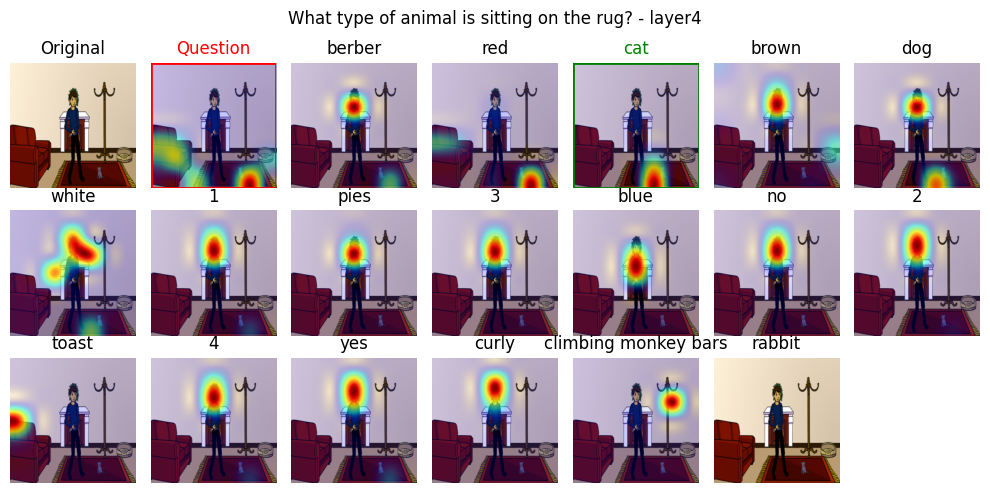

Correct Answer:  2 ######################
Question:  What type of animal is sitting on the rug? ######################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

correct


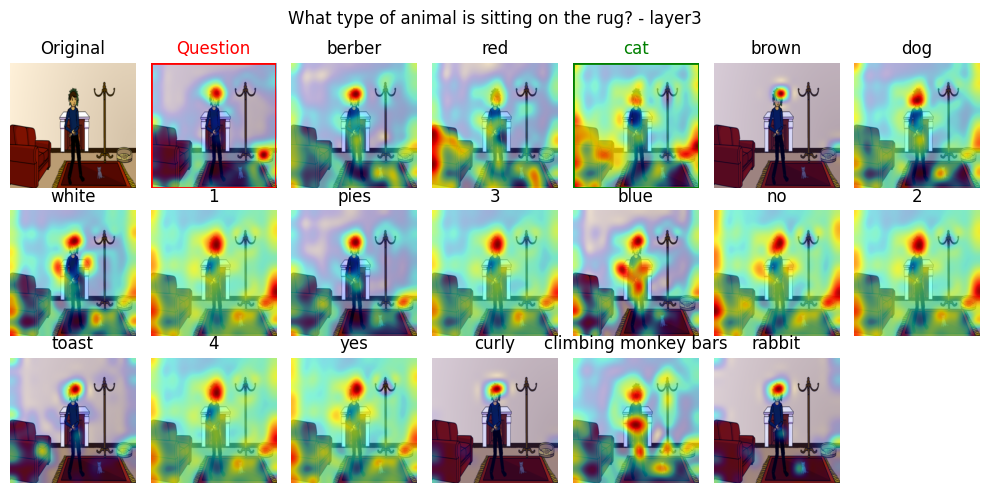

Correct Answer:  2 ######################
Question:  What type of animal is sitting on the rug? ######################
correct


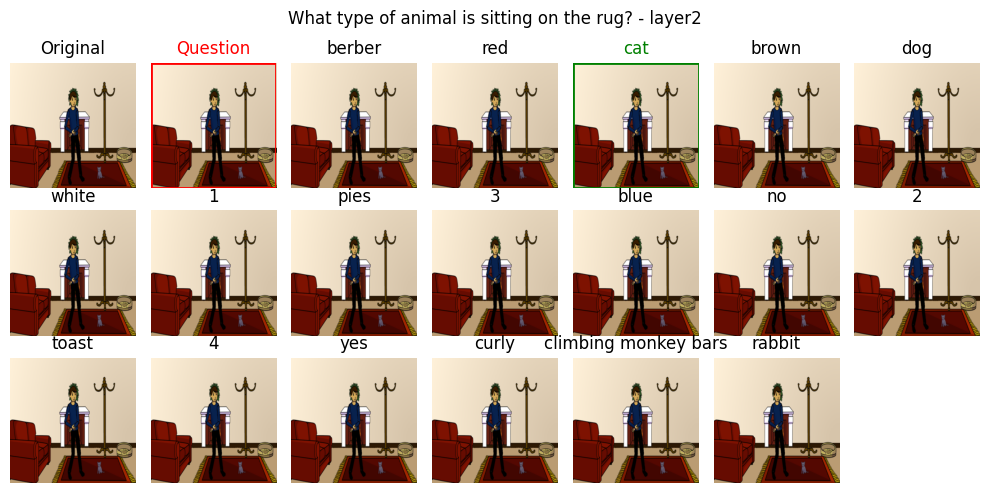

Correct Answer:  2 ######################
Question:  What type of animal is sitting on the rug? ######################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

correct


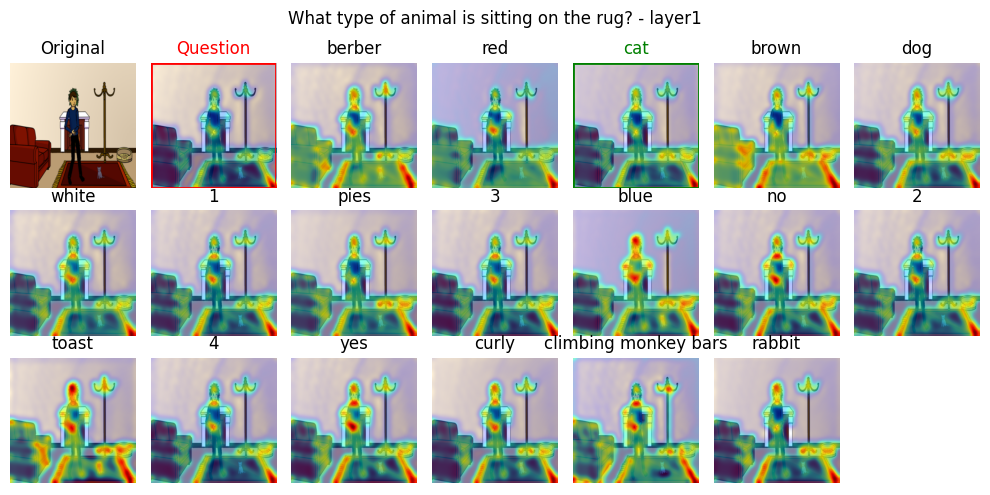

Correct Answer:  2 ######################


In [26]:


# load image

for saliency_layer in saliency_layers:
    print("Question: ", question, "######################")
    question_input = clip.tokenize([question]).to(device)
    attn_maps = []
    attn_map = gradCAM(
        model.visual,
        image_input,
        model.encode_text(question_input).float(),
        getattr(model.visual, saliency_layer)
    )
    attn_map = attn_map.squeeze().detach().cpu().numpy()

    attn_maps.append(attn_map)

    for i, answer in enumerate(answers):
        #print("Answer: ", answer, "######################")
        answer_input = clip.tokenize(answer).to(device)
        attn_map_answers = gradCAM(
            model.visual,
            image_input,
            model.encode_text(answer_input).float(),
            getattr(model.visual, saliency_layer)
        )
        attn_map_answers = attn_map_answers.squeeze().detach().cpu().numpy()
        attn_maps.append(attn_map_answers)
    viz_attn(image_np, attn_maps, question, answers, correct_answer, saliency_layer, blur=blur)
    print("Correct Answer: ", correct_answer, "######################")

In [9]:
print(answers)
print(answers.index("cat"))
print(answers.index("red"))

['berber', 'red', 'cat', 'brown', 'dog', 'white', '1', 'pies', '3', 'blue', 'no', '2', 'toast', '4', 'yes', 'curly', 'climbing monkey bars', 'rabbit']
2
1


Question:  What type of animal is sitting on the rug? ######################
4


C:\Users\mr_pa\AppData\Local\Temp\ipykernel_30340\344540541.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 :  2
1 :  3


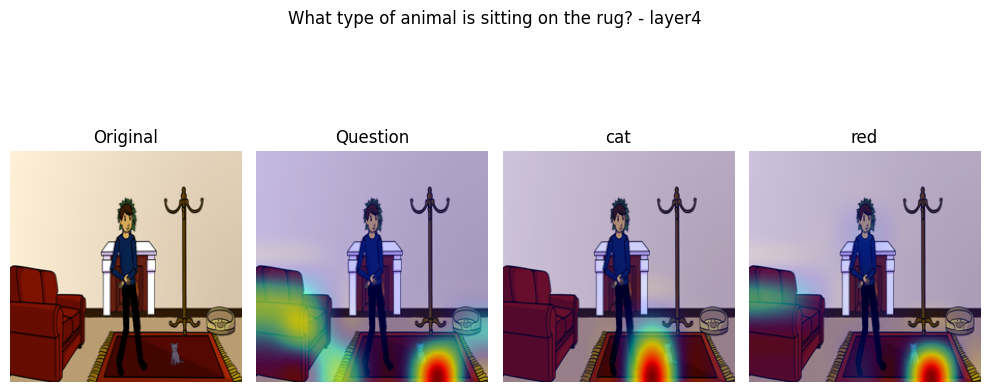

In [17]:
saliency_layer = "layer4"
print("Question: ", question, "######################")
question_input = clip.tokenize([question]).to(device)
attn_maps = []
attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(question_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

attn_maps.append(attn_map)
answer_selected = []
answer_selected.append(answers[answers.index("cat")])
answer_selected.append(answers[answers.index("red")])

for i, answer in enumerate(answer_selected):
    #print("Answer: ", answer, "######################")
    answer_input = clip.tokenize(answer).to(device)
    attn_map_answers = gradCAM(
        model.visual,
        image_input,
        model.encode_text(answer_input).float(),
        getattr(model.visual, saliency_layer)
    )
    attn_map_answers = attn_map_answers.squeeze().detach().cpu().numpy()
    attn_maps.append(attn_map_answers)
viz_attn2(image_np, attn_maps, question, answer_selected,2, saliency_layer, blur=blur)